# AMCPR GA (Initial Version)

In [2]:
#data & graph libraries
import pandas as pd

#Load Libraries for GA authorization
from oauth2client.service_account import ServiceAccountCredentials
from apiclient.discovery import build
import httplib2

In [3]:
#tutorial: https://www.jcchouinard.com/google-analytics-api-using-python/

#Create service credentials
#Rename your JSON key to client_secrets.json and save it to your working folder
credentials = ServiceAccountCredentials.from_json_keyfile_name('json', ['https://www.googleapis.com/auth/analytics.readonly'])
  
#Create a service object
http = credentials.authorize(httplib2.Http())
service = build('analytics', 'v4', http=http, discoveryServiceUrl=('https://analyticsreporting.googleapis.com/$discovery/rest'))


In [34]:
#Create a service object -> basic [users, sessions, bounces, pageviews, etc]
#https://ga-dev-tools.appspot.com/query-explorer/#report-end
http = credentials.authorize(httplib2.Http())
service = build('analytics', 'v4', http=http, discoveryServiceUrl=('https://analyticsreporting.googleapis.com/$discovery/rest'))
basic = service.reports().batchGet(
    body={
        'reportRequests': [
            {
                'viewId': '239937465', #Add View ID from GA
                'dateRanges': [{'startDate': '2021-02-01', 'endDate': 'today'}],
                'metrics': [
                    {'expression': 'ga:users'},
                    {"expression": "ga:bounces"},
                    {"expression": "ga:sessionDuration"},
                    {"expression": "ga:pageviews"}
                ], 
                'dimensions': [{"name": "ga:date"}],
                'pageSize': 100
            }]
    }
).execute()
 

In [32]:
#Create a service object -> event tracking (so downloads and the like)
http = credentials.authorize(httplib2.Http())
service = build('analytics', 'v4', http=http, discoveryServiceUrl=('https://analyticsreporting.googleapis.com/$discovery/rest'))
event = service.reports().batchGet(
    body={
        'reportRequests': [
            {
                'viewId': '239937465', #Add View ID from GA
                'dateRanges': [{'startDate': '2021-02-01', 'endDate': 'today'}],
                'metrics': [
                    {'expression': 'ga:users'},
                    {"expression": "ga:uniqueEvents"},
                    {"expression": "ga:totalEvents"},
                    {"expression": "ga:sessionsWithEvent"},
                    {"expression": "ga:eventValue"}
                ], 
                'dimensions': [
                    {"name": "ga:eventCategory"},
                    {"name": "ga:eventAction"},
                    {"name": "ga:date"},
                    {"name": "ga:eventLabel"}
                              ],
                'pageSize': 100
            }]
    }
).execute()
 

## Data Cleaning & Ordering 

In [24]:
#concerning making the response a readable json. 
#https://janakiev.com/blog/python-google-analytics/ 
import pandas as pd

In [19]:
def ga_response_dataframe(response):
    row_list = []
    # Get each collected report
    for report in response.get('reports', []):
        # Set column headers
        column_header = report.get('columnHeader', {})
        dimension_headers = column_header.get('dimensions', [])
        metric_headers = column_header.get('metricHeader', {}).get('metricHeaderEntries', [])
    
        # Get each row in the report
        for row in report.get('data', {}).get('rows', []):
            # create dict for each row
            row_dict = {}
            dimensions = row.get('dimensions', [])
            date_range_values = row.get('metrics', [])

            # Fill dict with dimension header (key) and dimension value (value)
            for header, dimension in zip(dimension_headers, dimensions):
                row_dict[header] = dimension

            # Fill dict with metric header (key) and metric value (value)
            for i, values in enumerate(date_range_values):
                for metric, value in zip(metric_headers, values.get('values')):
                # Set int as int, float a float
                    if ',' in value or '.' in value:
                        row_dict[metric.get('name')] = float(value)
                    else:
                        row_dict[metric.get('name')] = int(value)

            row_list.append(row_dict)
    return pd.DataFrame(row_list)

In [68]:
basicdf = ga_response_dataframe(basic)
basicdf["ga:date"] = pd.to_datetime(basicdf["ga:date"])
basicdf = basicdf.sort_values(by=['ga:date'])
basicdf.head()

,ga:date,ga:users,ga:bounces,ga:sessionDuration,ga:pageviews
0,2021-03-26,2,1,559.0,17
1,2021-03-31,1,1,298.0,6
2,2021-04-01,3,1,13459.0,232
3,2021-04-02,5,1,11284.0,212
4,2021-04-03,1,0,321.0,7


In [67]:
eventdf = ga_response_dataframe(event)
eventdf["ga:date"] = pd.to_datetime(eventdf["ga:date"])
eventdf=eventdf.sort_values(by=['ga:date'])
eventdf

,ga:eventCategory,ga:eventAction,ga:date,ga:eventLabel,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventValue
44,Downloads,PDF,2021-04-02,/download-file/amcprqrepo/cc8b46f3-dfe9-4945-b...,1,1,1,1,0
45,Downloads,PDF,2021-04-02,/system/files/design_request_uploads/ATDP-202%...,1,1,1,0,0
46,Downloads,PDF,2021-04-02,/system/files/design_request_uploads/ATDP-202%...,1,1,1,1,0
31,Downloads,JPG,2021-04-04,/system/files/design_request_uploads/hard%20ha...,1,1,1,1,0
47,Downloads,PDF,2021-04-05,/download-file/amcprqrepo/3c18d8a6-ff63-40cf-8...,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
28,Downloads,DOCX,2021-04-28,/system/files/tdp_uploads/2798/Fuel%20Elbow%20...,1,1,1,0,0
27,Downloads,DOCX,2021-04-28,/download-file/amcprqrepo/94482f7b-0cfa-4232-8...,1,1,1,0,0
43,Downloads,JPG,2021-05-06,/download-file/amcprqrepo/94482f7b-0cfa-4232-8...,1,1,1,1,0
30,Downloads,DOCX,2021-05-10,/download-file/amcprqrepo/94482f7b-0cfa-4232-8...,1,1,1,0,0


## Graphing: 

### Matplotlib Graphs: 

In [48]:
import matplotlib.pyplot as plt

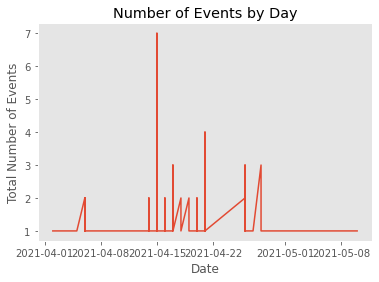

In [69]:
fig, ax = plt.subplots()
ax.plot(eventdf["ga:date"], eventdf["ga:totalEvents"])

ax.set(xlabel='Date', ylabel='Total Number of Events',
       title='Number of Events by Day')
ax.grid()

plt.show()

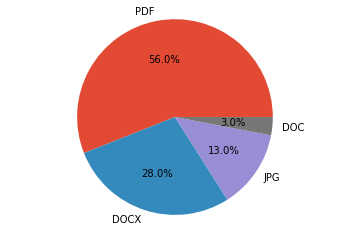

In [99]:
eventCount = eventdf["ga:eventAction"].value_counts()
labels= ["PDF", "DOCX", "JPG", "DOC"]
fig1, ax1 = plt.subplots()
ax1.pie(eventCount, labels = labels, autopct='%1.1f%%',)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Plotly Graphs: 

In [62]:
import plotly.express as px

In [71]:
fig = px.bar(eventdf, x="ga:date", y="ga:totalEvents", hover_name="ga:totalEvents")
fig.show()

In [98]:
eventCount = eventdf["ga:eventAction"].value_counts()
labels= ["PDF", "DOCX", "JPG", "DOC"]
fig = px.pie(values=eventCount, names=labels, title='Types of Downloaded File')
fig.show()